In [1]:
import tensorflow as tf

In [2]:
pip install --user tensorflow==2.0.0-beta1

Note: you may need to restart the kernel to use updated packages.


In [3]:
tf.__version__

'2.0.0-beta1'

In [4]:
import matplotlib.pylab as plt
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
import numpy as np

## Loading the data:

In [5]:
import pathlib
import os

In [6]:
data_root = pathlib.Path('./data')

In [7]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

2778

In [8]:
all_image_paths[:5]

['data\\amphibious vehicles\\69.re-enactors-aboard-a-ww2-amphibious-vehicle-FY86DD.jpg',
 'data\\Road vehicles\\29.sydneytrains-header.jpg',
 'data\\Road vehicles\\60.Uptown-Collision-Center-Flooded-Vehicles-1-min.jpg',
 'data\\Air Vehicles\\138.Dragon_Carousel_0007_2.jpg',
 'data\\Road vehicles\\61.az-large-477326.jpg']

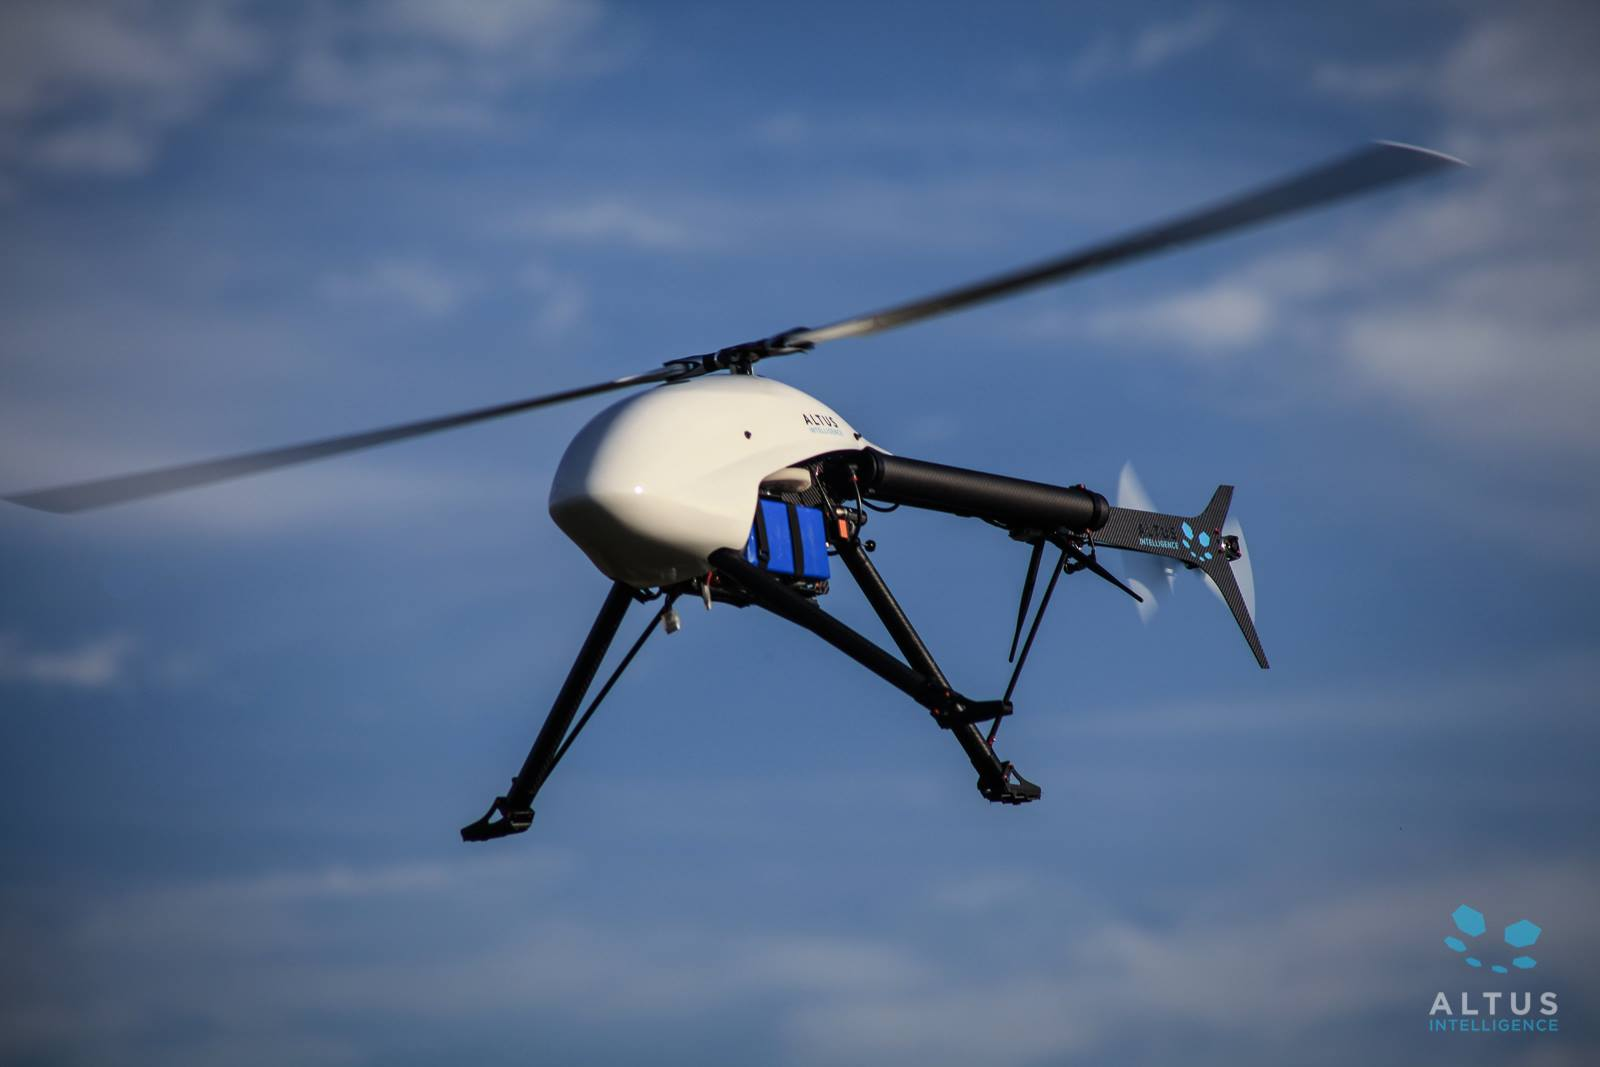

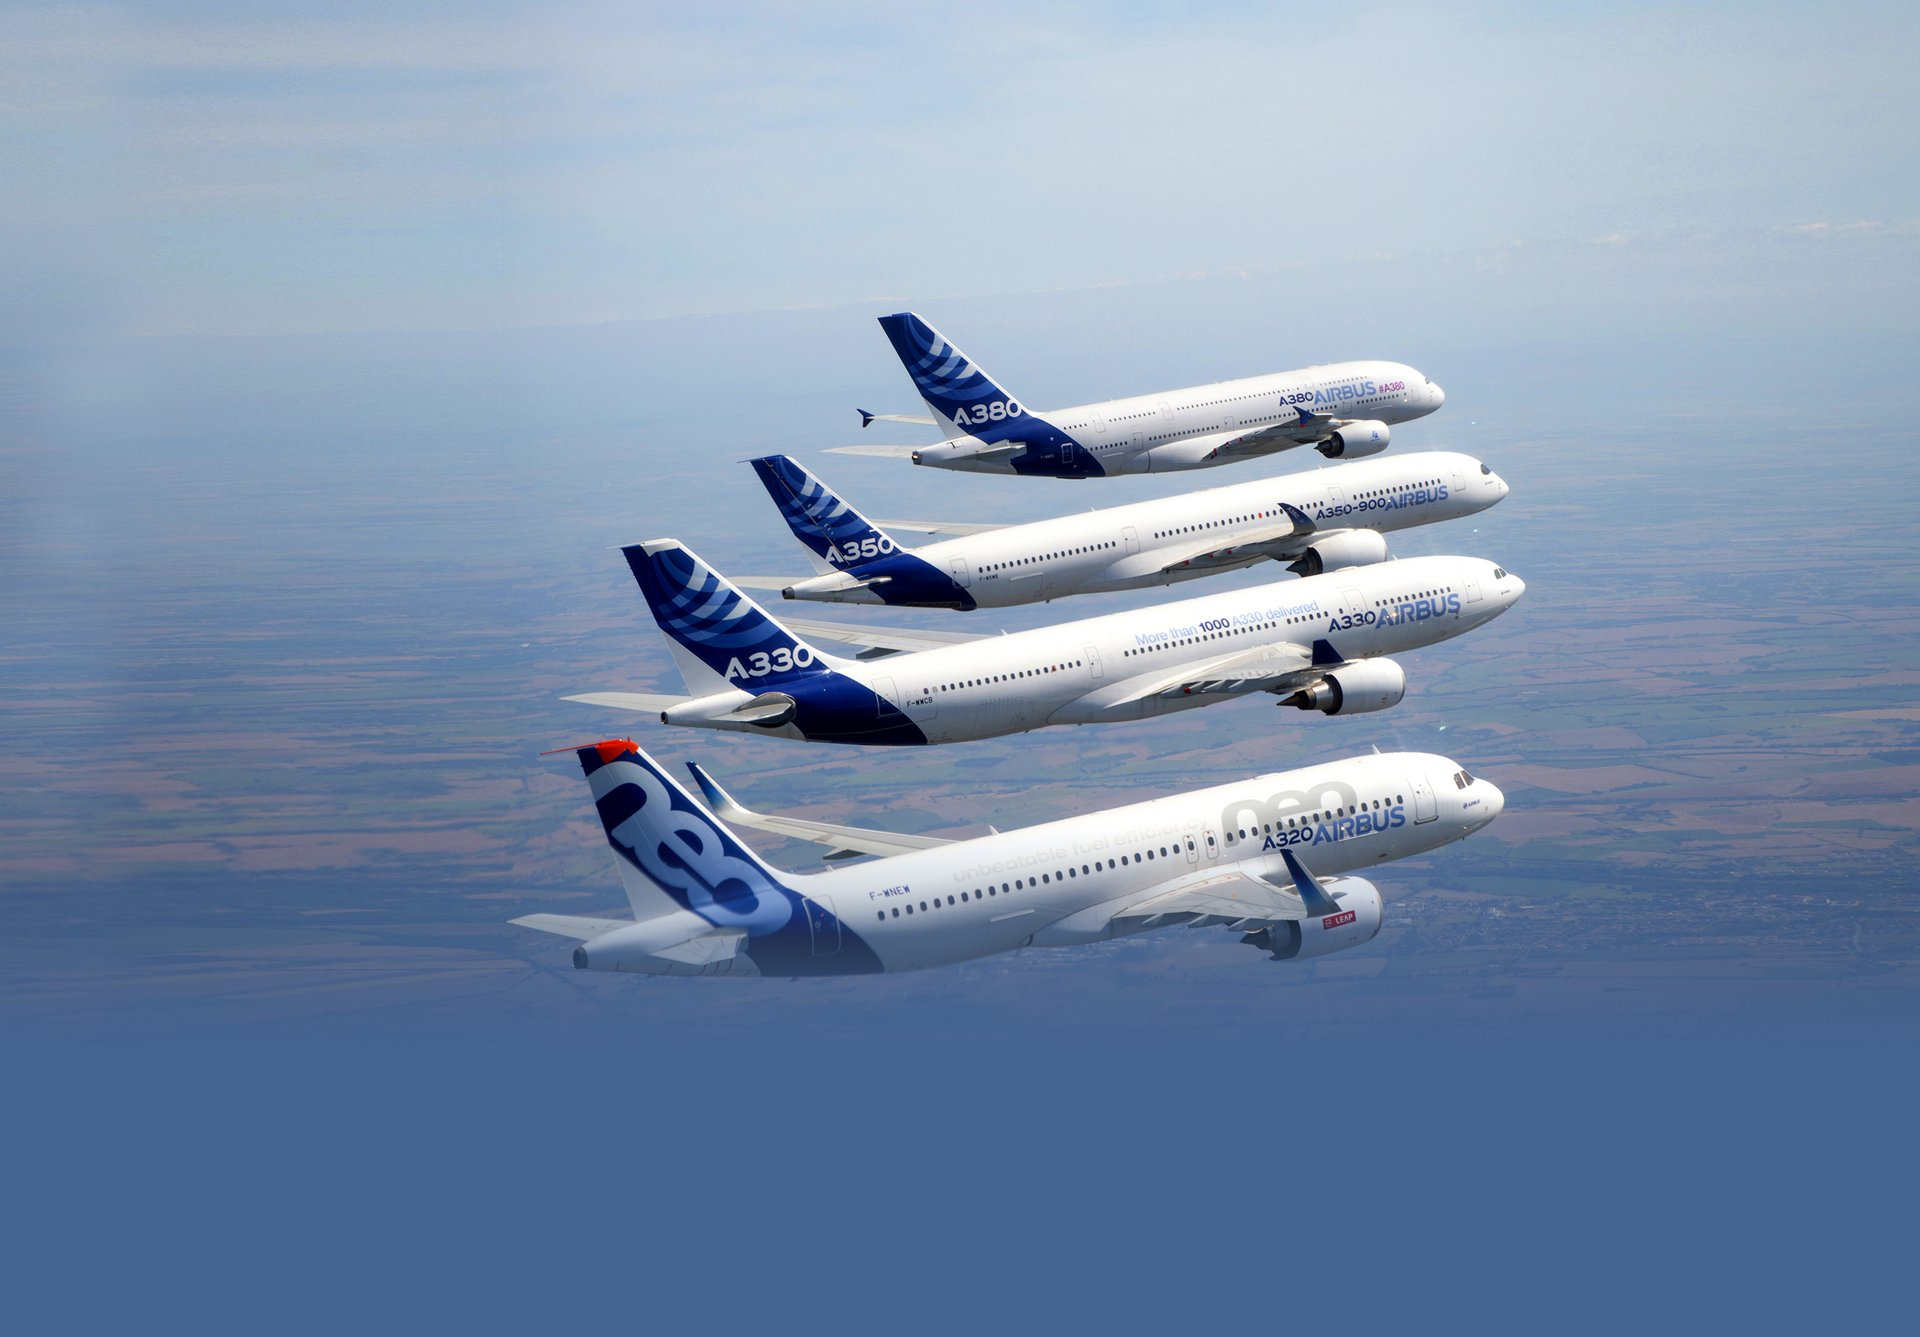

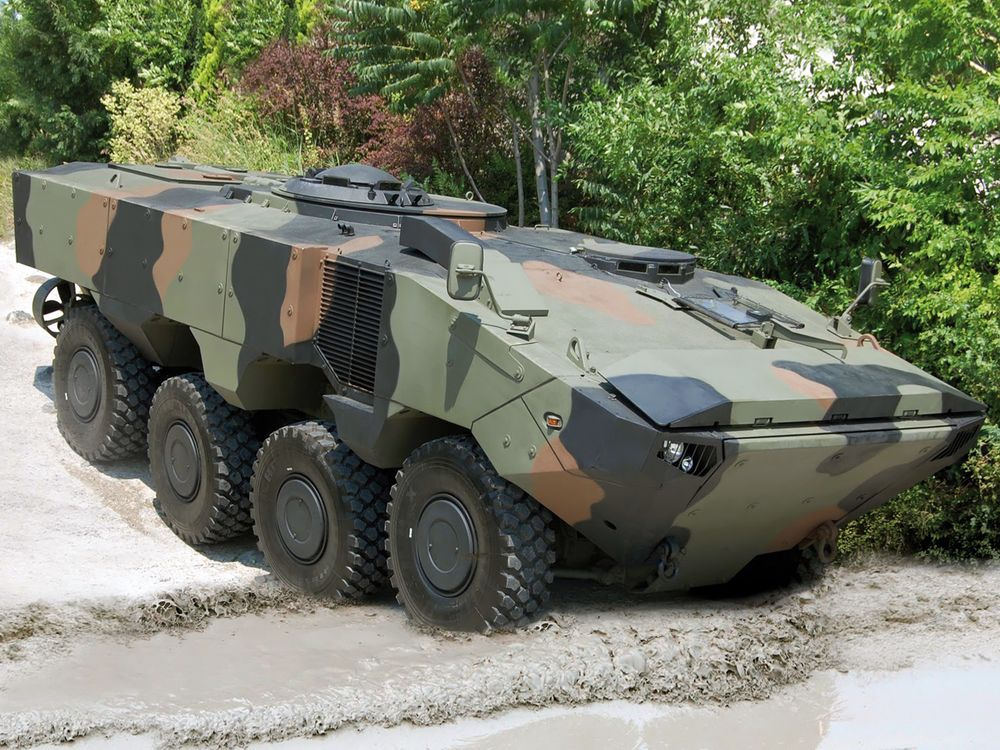

In [11]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print()

In [12]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names = np.array(label_names)
label_names

array(['Air Vehicles', 'Road vehicles', 'Water Vehicles',
       'amphibious vehicles'], dtype='<U19')

## Set index for Labels:

In [13]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'Air Vehicles': 0,
 'Road vehicles': 1,
 'Water Vehicles': 2,
 'amphibious vehicles': 3}

## Set Label for each image:

In [14]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 1, 1, 0, 1, 0, 0, 1, 0, 1]


## Count Images for each Folder:

In [15]:
# Count #image each class
from collections import Counter
count = Counter()

for label in all_image_labels:
    count[label_names[label]] += 1
  
count

Counter({'amphibious vehicles': 253,
         'Road vehicles': 1093,
         'Air Vehicles': 788,
         'Water Vehicles': 644})

## Pre-processing Part:

In [16]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

W1001 13:38:17.564146  6768 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data\Road vehicles\24.FloodedCar-58d00cd15f9b581d72c0f940.jpg


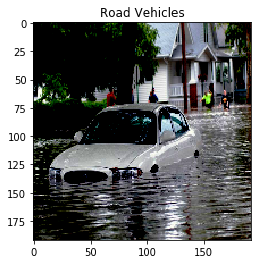

In [17]:
index = random.randint(0, image_count)
image_path = all_image_paths[index]
label = all_image_labels[index]

print(image_path)

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

In [26]:
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_ds(all_image_paths, all_image_labels):
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)

    # Setting a shuffle buffer size as large as the dataset ensures that the data is
    # completely shuffled.
    ds = image_label_ds.shuffle(buffer_size=image_count)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [27]:
train_set = create_ds(train_image_paths, train_image_labels)
test_set = create_ds(test_image_paths, test_image_labels)

## Model Summary:

In [28]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


## Customized Callback:

In [29]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
#         self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
#         self.model.reset_metrics()

In [30]:
steps_per_epoch = tf.math.ceil(0.8 * image_count/BATCH_SIZE).numpy()
val_steps_per_epoch = tf.math.ceil(0.2 * image_count/BATCH_SIZE).numpy()
batch_stats_callback = CollectBatchStats()

history = model.fit(train_set, epochs=10, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback],
            validation_data=test_set,
            validation_steps=val_steps_per_epoch)

Epoch 1/10


W1001 13:40:38.620079  6768 deprecation.py:323] From C:\Users\Admin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


70/70 [==============================] - 737s 11s/step - loss: 1.2887 - accuracy: 0.4152 - val_loss: 1.0751 - val_accuracy: 0.5365
Epoch 2/10
70/70 [==============================] - 545s 8s/step - loss: 1.0191 - accuracy: 0.5964 - val_loss: 0.8642 - val_accuracy: 0.6649
Epoch 3/10
70/70 [==============================] - 515s 7s/step - loss: 0.8664 - accuracy: 0.6799 - val_loss: 0.7177 - val_accuracy: 0.7500
Epoch 4/10
70/70 [==============================] - 576s 8s/step - loss: 0.7419 - accuracy: 0.7446 - val_loss: 0.6285 - val_accuracy: 0.7986
Epoch 5/10
70/70 [==============================] - 579s 8s/step - loss: 0.6519 - accuracy: 0.7937 - val_loss: 0.5585 - val_accuracy: 0.8316
Epoch 6/10
70/70 [==============================] - 542s 8s/step - loss: 0.5898 - accuracy: 0.8058 - val_loss: 0.5113 - val_accuracy: 0.8490
Epoch 7/10
70/70 [==============================] - 606s 9s/step - loss: 0.5469 - accuracy: 0.8277 - val_loss: 0.4777 - val_accuracy: 0.8576
Epoch 8/10
70/70 [=====

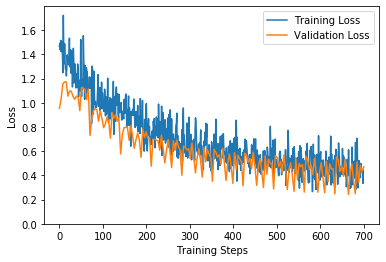

In [31]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()
    
plot_loss(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses)

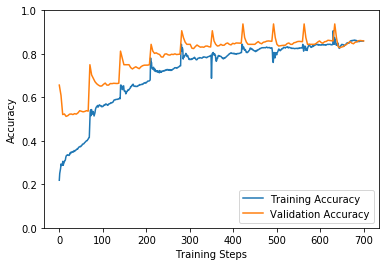

In [32]:
def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()
    
plot_accuracy(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc)

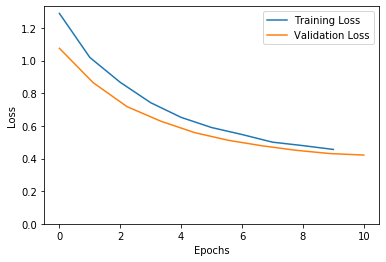

In [33]:
plot_loss(history.history['loss'], history.history['val_loss'], x_label='Epochs')

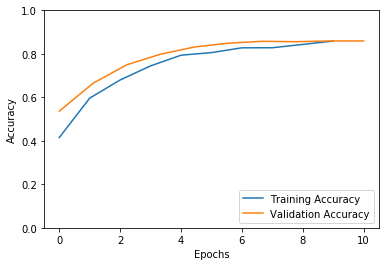

In [34]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'], x_label='Epochs')

## Data Augmentation using ImageDataGenerator

In [35]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)


In [36]:
import pandas as pd

df = pd.DataFrame({'paths':train_image_paths, 'labels':label_names[train_image_labels]})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222 entries, 0 to 2221
Data columns (total 2 columns):
paths     2222 non-null object
labels    2222 non-null object
dtypes: object(2)
memory usage: 34.8+ KB


In [37]:
# image_data = image_generator.flow_from_directory(str(data_root), target_size=(192,192))
image_data = image_generator.flow_from_dataframe(df,
                                                 x_col='paths',
                                                 y_col='labels',
                                                 class_mode='sparse',
                                                 target_size=(192,192))

Found 2222 validated image filenames belonging to 4 classes.


In [38]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
steps_per_epoch = tf.math.ceil(0.8 * image_count/BATCH_SIZE).numpy()
val_steps_per_epoch = tf.math.ceil(0.2 * image_count/BATCH_SIZE).numpy()
batch_stats_callback_2 = CollectBatchStats()

initial_epochs = 10
history = model.fit(image_data, epochs=initial_epochs, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback_2],
            validation_data=test_set,
            validation_steps=val_steps_per_epoch)

Epoch 1/10
70/70 [==============================] - 668s 10s/step - loss: 1.3929 - accuracy: 0.3726 - val_loss: 1.2910 - val_accuracy: 0.4167
Epoch 2/10
70/70 [==============================] - 640s 9s/step - loss: 1.2189 - accuracy: 0.4640 - val_loss: 1.0924 - val_accuracy: 0.5191
Epoch 3/10
70/70 [==============================] - 579s 8s/step - loss: 1.0670 - accuracy: 0.5617 - val_loss: 0.9350 - val_accuracy: 0.6076
Epoch 4/10
70/70 [==============================] - 601s 9s/step - loss: 0.9745 - accuracy: 0.6080 - val_loss: 0.8233 - val_accuracy: 0.6806
Epoch 5/10
70/70 [==============================] - 601s 9s/step - loss: 0.9111 - accuracy: 0.6422 - val_loss: 0.7345 - val_accuracy: 0.7309
Epoch 6/10
70/70 [==============================] - 605s 9s/step - loss: 0.8415 - accuracy: 0.6827 - val_loss: 0.6710 - val_accuracy: 0.7778
Epoch 7/10
70/70 [==============================] - 599s 9s/step - loss: 0.7998 - accuracy: 0.6953 - val_loss: 0.6215 - val_accuracy: 0.7812
Epoch 8/10
7

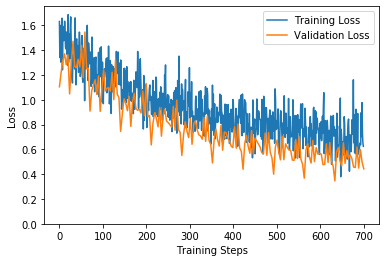

In [40]:
plot_loss(batch_stats_callback_2.batch_losses, batch_stats_callback_2.batch_val_losses)

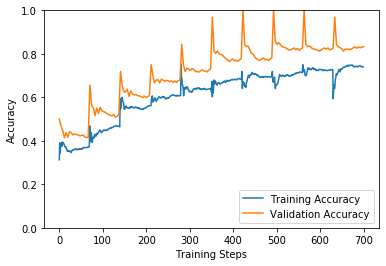

In [41]:
plot_accuracy(batch_stats_callback_2.batch_acc, batch_stats_callback_2.batch_val_acc)

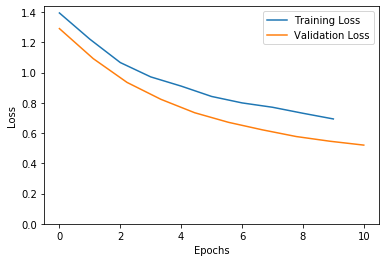

In [42]:
plot_loss(history.history['loss'], history.history['val_loss'], x_label='Epochs')

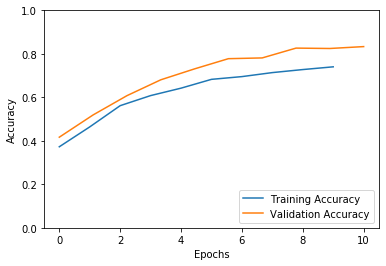

In [43]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'], x_label='Epochs')

## Fine Tuning the Pretrained Model:

In [44]:
mobile_net.trainable=True

In [45]:
print("Number of layers in the base model:", len(mobile_net.layers))

fine_tune_at = 145

for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 155


In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 737,604
Non-trainable params: 1,525,504
_________________________________________________________________


In [47]:
print("Number of trainable variables:", len(model.trainable_variables))

Number of trainable variables: 13


In [48]:
steps_per_epoch = tf.math.ceil(0.8 * image_count/BATCH_SIZE).numpy()
val_steps_per_epoch = tf.math.ceil(0.2 * image_count/BATCH_SIZE).numpy()

fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs
history = model.fit(image_data, epochs=total_epochs, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback_2],
            validation_data=test_set,
            validation_steps=val_steps_per_epoch,
            initial_epoch=initial_epochs)

Epoch 11/30
70/70 [==============================] - 565s 8s/step - loss: 0.6736 - accuracy: 0.7592 - val_loss: 0.4652 - val_accuracy: 0.8524
Epoch 12/30
70/70 [==============================] - 9027s 129s/step - loss: 0.6302 - accuracy: 0.7574 - val_loss: 0.4226 - val_accuracy: 0.8594
Epoch 13/30
70/70 [==============================] - 554s 8s/step - loss: 0.5947 - accuracy: 0.7754 - val_loss: 0.3954 - val_accuracy: 0.8628
Epoch 14/30
70/70 [==============================] - 553s 8s/step - loss: 0.5566 - accuracy: 0.7925 - val_loss: 0.3721 - val_accuracy: 0.8681
Epoch 15/30
70/70 [==============================] - 547s 8s/step - loss: 0.5238 - accuracy: 0.8074 - val_loss: 0.3557 - val_accuracy: 0.8733
Epoch 16/30
70/70 [==============================] - 541s 8s/step - loss: 0.5165 - accuracy: 0.8024 - val_loss: 0.3397 - val_accuracy: 0.8767
Epoch 17/30
70/70 [==============================] - 536s 8s/step - loss: 0.5128 - accuracy: 0.8146 - val_loss: 0.3282 - val_accuracy: 0.8785
Epo

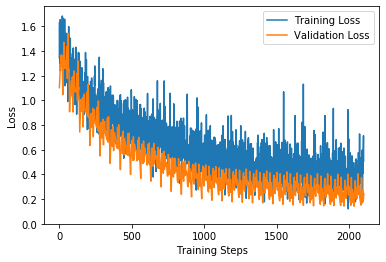

In [49]:
plot_loss(batch_stats_callback_2.batch_losses, batch_stats_callback_2.batch_val_losses)

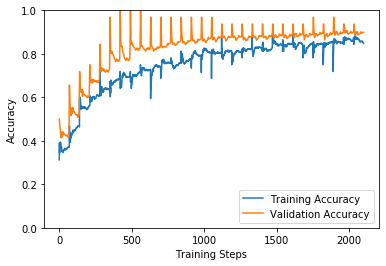

In [50]:
plot_accuracy(batch_stats_callback_2.batch_acc, batch_stats_callback_2.batch_val_acc)

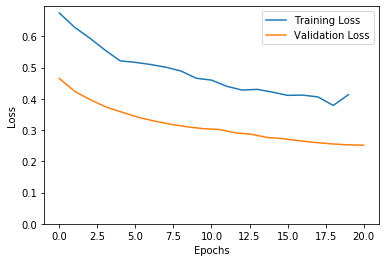

In [51]:
plot_loss(history.history['loss'], history.history['val_loss'], x_label='Epochs')

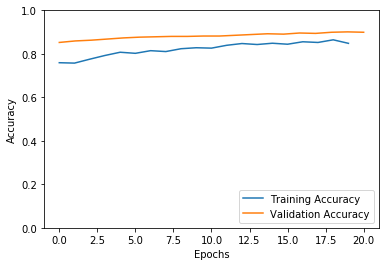

In [52]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'], x_label='Epochs')

## Testing and Preview

In [53]:
# Take 1 batch out to test

for image_batch, label_batch in test_set:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 192, 192, 3)
Label batch shape:  (32,)


In [54]:
label_names = np.array(label_names)
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

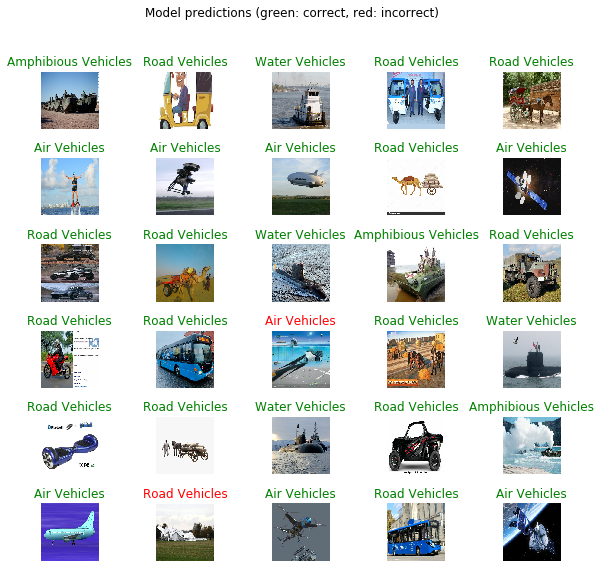

In [55]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow((image_batch[n]+1)/2)
  #plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_batch.numpy()[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [56]:
model.save('model2.h5')

In [57]:

reloaded_model = tf.keras.models.load_model('model2.h5')
reloaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 737,604
Non-trainable params: 1,525,504
_________________________________________________________________


In [58]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [59]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [60]:
test_model = tf.keras.models.load_model('model2.h5')


In [61]:
test_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 737,604
Non-trainable params: 1,525,504
_________________________________________________________________


In [62]:
path = 'data\\Road vehicles\\291.avtoros-shaman-8x8.jpg'

In [63]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range
    image = tf.expand_dims(image, axis=0)
    
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [64]:
image_decode = load_and_preprocess_image(path)
image_decode.shape

TensorShape([1, 192, 192, 3])

In [65]:
test_model.predict(image_decode)

array([[0.03671654, 0.8583478 , 0.04079005, 0.06414558]], dtype=float32)

In [66]:
array = test_model.predict(image_decode)

In [67]:
array_flat =array.flatten()

In [68]:
array_list = array_flat.tolist()

In [69]:
array_list

[0.03671653941273689,
 0.8583477735519409,
 0.04079005494713783,
 0.06414557993412018]

In [70]:
lst_of_keys = []
for key in label_to_index.keys():
    lst_of_keys.append(key)

In [71]:
lst_of_keys

['Air Vehicles', 'Road vehicles', 'Water Vehicles', 'amphibious vehicles']

In [72]:
lst_of_keys[array_list.index(max(array_list))]

'Road vehicles'